# Equivalent water thickness/canopy water content from AVIRIS-NG data
This tutorial shows how to calculate equivalent water thickness or canopy water content (CWC) from [AVIRIS-NG](https://daac.ornl.gov/cgi-bin/dataset_lister.pl?p=47) data. Variation in CWC can indicate drought stress and wildfire risk.

We will apply a simple fitting of spectral absorption features of liquid water and use scripts available from [ISOFIT package](https://github.com/isofit/isofit/tree/main).

## Canopy Water Content (CWC)
First, surface reflectance was derived using the Optimal Estimation-based simultaneous modeling of surface and atmosphere through the ISOFIT codebase. Derived surface reflectance spectra were particularly smooth in water absorption bands and include estimates of per-band posterior uncertainties (Thompson et al. 2018).

The CWS was then derived from surface reflectance by applying a well-validated algorithm based on a physical model (Beer-Lambert model) (Green et al. 2006; Bohn et al. 2020). Of note, this model does not account for multiple scattering effects within the canopy and may result in overestimation of retrieved CWC (Bohn et al. 2020).

## References
- Bohn, N., L. Guanter, T. Kuester, R. Preusker, and K. Segl. 2020. Coupled retrieval of the three phases of water from spaceborne imaging spectroscopy measurements. Remote Sensing of Environment 242:111708. https://doi.org/10.1016/j.rse.2020.111708
- Green, R.O., T.H. Painter, D.A. Roberts, and J. Dozier. 2006. Measuring the expressed abundance of the three phases of water with an imaging spectrometer over melting snow. Water Resources Research 42:W10402. https://doi.org/10.1029/2005WR004509
- Thompson, D.R., V. Natraj, R.O. Green, M.C. Helmlinger, B.-C. Gao, and M.L. Eastwood. 2018. Optimal estimation for imaging spectrometer atmospheric correction. Remote Sensing of Environment 216:355–373. https://doi.org/10.1016/j.rse.2018.07.003

## Datasets
-  Bohn, N., P.G. Brodrick, and K.D. Chadwick. 2023. SHIFT: AVIRIS-NG Derived Gridded Mosaicked Canopy Water Content, California, 2022. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2242
-  Green, R.O., P.G. Brodrick, J.W. Chapman, M. Eastwood, S. Geier, M. Helmlinger, S.R. Lundeen, W. Olson-Duvall, R. Pavlick, L.M. Rios, D.R. Thompson, and A.K. Thorpe. 2023. AVIRIS-NG L2 Surface Reflectance, Facility Instrument Collection, V1. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2110

## Import modules
Let's first import the required python modules.

In [3]:
import requests
import rasterio
import rioxarray
import boto3
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from os import path
from scipy.optimize import least_squares

## Retrieve AVIRIS-NG Spectra

### Install rasterio

```bash 
pip install rasterio[s3]
```

### AVIRIS-NG File
S3 links to AVIRIS-NG file can be obtained from [NASA Earthdata Search](https://search.earthdata.nasa.gov/search/granules?p=C2659129205-ORNL_CLOUD). We will use one file `ang20200731t193625_corr_v2y1_img` and retrieve it using rasterio. The bounding polygon of this file is located at `data/ang20200731t193625_corr_v2y1_img.geojson` and overlaps the area of [Sedgwick Reserve](https://nrs.ucsb.edu/sedgwick-reserve/) as shown in the plot below.

In [76]:
# avirisng S3 link
s3_url = 's3://ornl-cumulus-prod-protected/aviris/AVIRIS-NG_L2_Reflectance/data/ang20200731t193625_corr_v2y1_img.bin'
# open bounding geometry
sedgwick = gpd.read_file('data/ang20200731t193625_corr_v2y1_img.geojson')
# reproject to UTM 10N and get centroid of the polygon
c = sedgwick.to_crs(epsg=32610).centroid.to_crs(epsg=4326)
# create a map centering on centroid
f = folium.Figure(width=500, height=300)
m = folium.Map(location=[c.y[0], c.x[0]], zoom_start=9, max_bounds=True).add_to(f)
# create ESRI satellite base map
esri = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
folium.TileLayer(tiles = esri, attr = 'Esri', name = 'Esri Satellite', overlay = False, control = True).add_to(m)
# add boundary polygon to the map
folium.GeoJson(data=sedgwick.to_json(), style_function=lambda x: {"fillOpacity": 0}).add_to(m)
# add centroid to the map
folium.Marker(location=[c.y[0], c.x[0]]).add_to(m)
m

### S3 Credentials
Follow instruction here to setup NASA Earthdata access: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget

Once the `.netrc` file is setup as above, we have access to all NASA Earthdata datasets and other resources. We can also retrieve temporary credentials for S3 access.

In [59]:
# s3 credentials
earthadata_s3 = f"https://data.ornldaac.earthdata.nasa.gov/s3credentials"
r = requests.get(earthadata_s3)
r.raise_for_status()
s3credentials = r.json()

# aws session using rasterio
session = boto3.Session(aws_access_key_id=s3credentials['accessKeyId'], 
                        aws_secret_access_key=s3credentials['secretAccessKey'],
                        aws_session_token=s3credentials['sessionToken'],
                        region_name='us-west-2')

### Access the AVIRIS-NG File
We can now pass above session to retrieve the AVIRIS-NG file using the `rasterio` module.

In [71]:
env = rasterio.Env(rasterio.session.AWSSession(session),
                  GDAL_DISABLE_READDIR_ON_OPEN='TRUE',
                  GDAL_HTTP_COOKIEFILE=path.expanduser('~/.urs_cookies.txt'),
                  GDAL_HTTP_COOKIEJAR=path.expanduser('~/.urs_cookies.txt'))
env.__enter__()
avirisng = rioxarray.open_rasterio(s3_url, driver='ENVI', chuncks=True, parse_coordinates=True)
avirisng

<xarray.DataArray (band: 425, y: 8371, x: 963)>
[3426041025 values with dtype=float32]
Coordinates:
    fwhm         (band) float64 5.57 5.58 5.58 5.58 5.59 ... 6.02 6.02 6.02 6.03
    wavelength   (band) float64 376.7 381.7 386.7 ... 2.49e+03 2.495e+03 2.5e+03
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 419 420 421 422 423 424 425
    xc           (y, x) float64 7.64e+05 7.64e+05 ... 7.766e+05 7.766e+05
    yc           (y, x) float64 3.861e+06 3.861e+06 ... 3.793e+06 3.793e+06
    spatial_ref  int64 0
Dimensions without coordinates: y, x
Attributes: (12/451)
    Band_1:                   376.719576 Nanometers
    Band_10:                  421.799576 Nanometers
    Band_100:                 872.579576 Nanometers
    Band_101:                 877.589576 Nanometers
    Band_102:                 882.5995760000001 Nanometers
    Band_103:                 887.599576 Nanometers
    ...                       ...
    radiance_version:         v2.0
    rcc_file:                 /home/jchapman/src/isat/ang/cal/data/20180727_a...
    samples:                  963
    smoothing_factors:         1.0 , 1.0 , 1.0 , 1.0 , 1.0 , 1.0 , 1.0 , 1.0 ...
    spectral_scatter_file:    /home/jchapman/src/isat/ang/cal/data/20170125_v...
    wavelength_file:          /home/jchapman/src/isat/ang/cal/data/20190111_a...

Let's retrieve a spectra from the AVIRIS-NG file and plot.

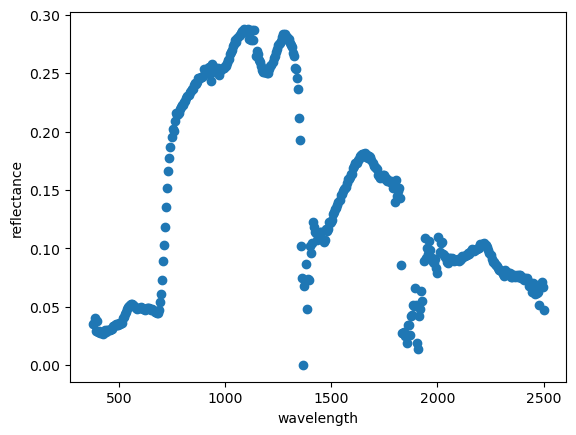

In [84]:
# xy = sedgwick.to_crs(avirisng.rio.crs).centroid
# rfl_meas = avirisng.isel(y=xy.y[0], x=xy.x[0]).values
rfl_meas = avirisng.isel(y=2000, x=300).values
wl = avirisng.wavelength.values
plt.scatter(wl, rfl_meas)
plt.xlabel("wavelength")
plt.ylabel("reflectance")
plt.show()

## Beer-lambert Law
Let's define a function that returns the vector of residuals between measured and modeled surface reflectance. The surface reflectance optimizes for path length of surface liquid water based on the Beer-Lambert attenuation law.

In [8]:
def beer_lambert_model(x, y, wl, alpha_lw):
    """
    Args:
        x:        state vector (liquid water path length, intercept, slope)
        y:        measurement (surface reflectance spectrum)
        wl:       instrument wavelengths
        alpha_lw: wavelength dependent absorption coefficients of liquid water

    Returns:
        resid: residual between modeled and measured surface reflectance
    """

    attenuation = np.exp(-x[0] * 1e7 * alpha_lw)
    rho = (x[1] + x[2] * wl) * attenuation
    resid = rho - y

    return resid

## Refractive indices of different water phases
There is a file at `data` folder called `k_liquid_water_ice.csv` which provides refractive indices of different water phases. This is the imaginary part of liquid water refractive index. Let's open that file and display the first few lines.

In [9]:
path_k = path.join("data", "k_liquid_water_ice.csv")
k_wi = pd.read_csv(path_k)
k_wi

,wvl_1,T = 22°C,wvl_2,T = -8°C,wvl_3,T = -25°C,wvl_4,T = -7°C,wvl_5,T = 25°C (H),wvl_6,T = 20°C,wvl_7,T = 25°C (S),Index
0,666.7,2.470000e-08,NaN,NaN,NaN,NaN,660.0,1.660000e-08,650.0,1.640000e-08,650.00,1.870000e-08,650.12971,1.674130e-08,0
1,667.6,2.480000e-08,NaN,NaN,NaN,NaN,670.0,1.890000e-08,675.0,2.230000e-08,651.00,1.890000e-08,654.63616,1.777420e-08,1
2,668.4,2.480000e-08,NaN,NaN,NaN,NaN,680.0,2.090000e-08,700.0,3.350000e-08,652.00,1.910000e-08,660.69347,1.939950e-08,2
3,669.3,2.520000e-08,NaN,NaN,NaN,NaN,690.0,2.400000e-08,725.0,9.150000e-08,653.00,1.940000e-08,665.27314,2.031380e-08,3
4,670.2,2.530000e-08,NaN,NaN,NaN,NaN,700.0,2.900000e-08,750.0,1.560000e-07,654.00,1.970000e-08,669.88461,2.097930e-08,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1745.00,8.540000e-05,NaN,NaN,977
978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1746.25,8.500000e-05,NaN,NaN,978
979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1747.50,8.500000e-05,NaN,NaN,979
980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1748.75,8.460000e-05,NaN,NaN,980


The table above provides imaginary part of the liquid water refractive index for seven temperatures. Let's plot these values.

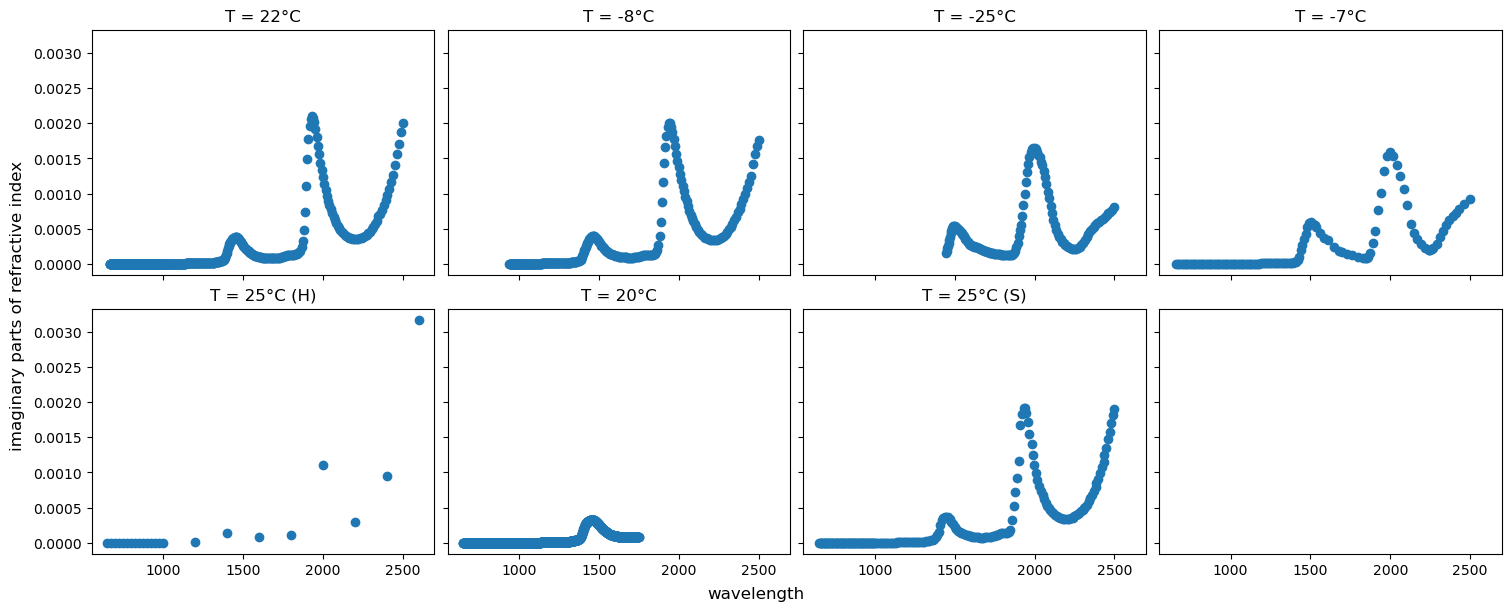

In [10]:
fig, axs = plt.subplots(2,4, figsize=(15, 6),  sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()
col_n = 0
for i in range(0, 7):
    x = k_wi.iloc[:, col_n+i]
    y = k_wi.iloc[:, col_n+i+1]
    axs[i].scatter(x, y)
    axs[i].set_title(y.name)
    col_n+=1
fig.supylabel('imaginary parts of refractive index')
fig.supxlabel('wavelength')
plt.show()

We will use `wvl_6` as the wavelength column and `T = 20°C` as the k column or imaginary parts of refractive index. 

In [12]:
# wavelengths
wl_water = k_wi['wvl_6'].to_numpy()
# imaginary parts of refractive index
k_water = k_wi['T = 20°C'].to_numpy()

## Inversion
Given a reflectance estimate, we will fit a state vector including liquid water path length based on a simple Beer-Lambert surface model defined above.

Let's first define some parameter and bounds>

In [13]:
# wavelength of left absorption feature shoulder
l_shoulder = 850.
# wavelength of right absorption feature shoulder
r_shoulder = 1100.
# initial guess for liquid water path length, intercept, and slope
lw_init = (0.02, 0.3, 0.0002)
# lower and upper bounds for liquid water path length, intercept, and slope
lw_bounds  = ([0, 0.5], [0, 1.0], [-0.0004, 0.0004])

# params needed for liquid water fitting
lw_feature_left = np.argmin(abs(l_shoulder - wl))
lw_feature_right = np.argmin(abs(r_shoulder - wl))
wl_sel = wl[lw_feature_left : lw_feature_right + 1]

kw = np.interp(x=wl_sel, xp=wl_water, fp=k_water)
abs_co_w = 4 * np.pi * kw / wl_sel

rfl_meas_sel = rfl_meas[lw_feature_left : lw_feature_right + 1]

x_opt = least_squares(
        fun=beer_lambert_model,
        x0=lw_init,
        jac="2-point",
        method="trf",
        bounds=(
            np.array([lw_bounds[ii][0] for ii in range(3)]),
            np.array([lw_bounds[ii][1] for ii in range(3)]),
        ),
        max_nfev=15,
        args=(rfl_meas_sel, wl_sel, abs_co_w),
    )

solution = x_opt.x

In [15]:
x_opt

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 2.358e-03  1.448e-04 ...  4.740e-05  3.595e-04]
           x: [ 1.363e-01  5.681e-02  2.160e-04]
        cost: 0.00015511327824415953
         jac: [[-9.695e-03  9.945e-01  8.428e+02]
               [-1.008e-02  9.943e-01  8.477e+02]
               ...
               [-4.931e-02  9.768e-01  1.068e+03]
               [-5.312e-02  9.751e-01  1.071e+03]]
        grad: [-1.803e-08  3.387e-08 -4.998e-06]
  optimality: 6.558946086579442e-09
 active_mask: [0 0 0]
        nfev: 9
        njev: 9